In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42) 
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


torch.Size([182441, 3])

In [15]:
(5/3)/(30**0.5)

0.3042903097250923

tensor(-0.0085) tensor(0.9916)
tensor(0.0011) tensor(0.9937)


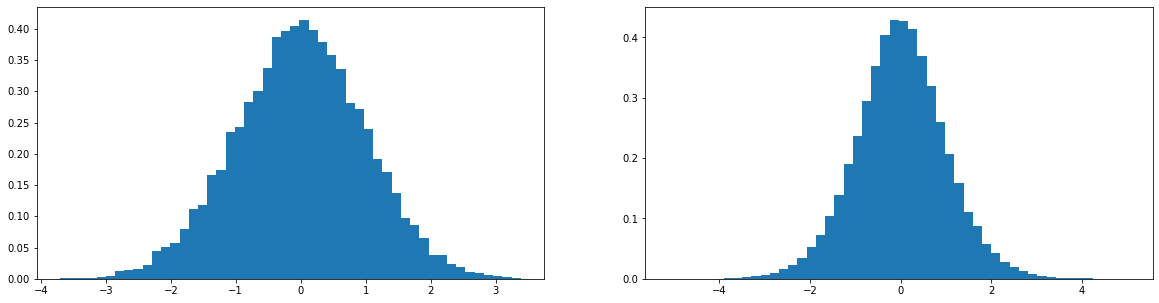

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [55]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) /(n_embd *block_size) #kaiming init 
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # its not doing anything cause its substracted in batch normalization thats why it's commented now
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1,b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [25]:
hpre_act.shape

torch.Size([32, 200])

In [28]:
hpre_act.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [31]:
hpre_act.std(0, keepdim=True).shape

torch.Size([1, 200])

In [58]:
#same optimization as last time removed some magic numbers
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    #     print(f'Xb: {Xb}')
    #     print(f'Yb: {Yb}')
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    #Linear layer
    hpre_act = embcat @ W1 #+ b1 #hidden layer  pre-activation

    #Batch norm layer
    # -------------------------------------------------------
    bnmeani = hpre_act.mean(0, keepdim=True)
    bnstdi = hpre_act.std(0, keepdim=True)
    hpre_act = bngain *(hpre_act -  bnmeani) / bnstdi +bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------
    
    #Non-linearity
    h = torch.tanh(hpre_act) #hidden layer 
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    #     print('loss',loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000  else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

#     break

      0/ 200000: 3.3147
  10000/ 200000: 2.1471
  20000/ 200000: 2.2606
  30000/ 200000: 2.4550
  40000/ 200000: 1.9365
  50000/ 200000: 2.3602
  60000/ 200000: 2.3991
  70000/ 200000: 2.1019
  80000/ 200000: 2.3497
  90000/ 200000: 2.1427
 100000/ 200000: 1.8667
 110000/ 200000: 2.2814
 120000/ 200000: 1.9126
 130000/ 200000: 2.5292
 140000/ 200000: 2.3574
 150000/ 200000: 2.1659
 160000/ 200000: 1.9289
 170000/ 200000: 1.8479
 180000/ 200000: 2.0889
 190000/ 200000: 1.8523


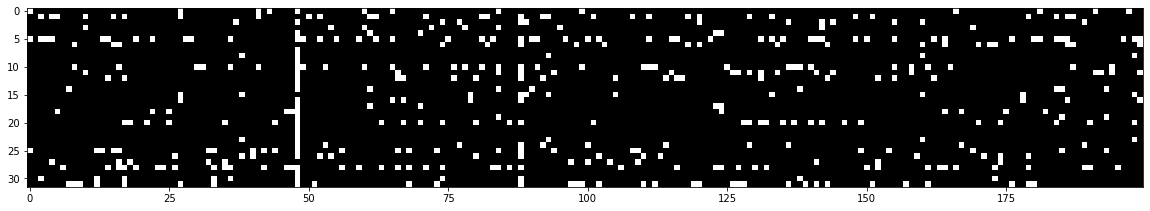

In [37]:
#checking h's that are close to 1, becuase there the gradient becomes flat for tanh
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

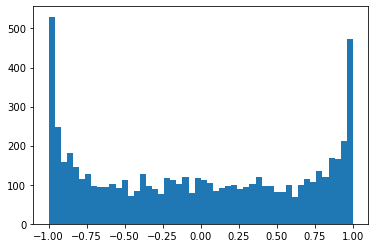

In [38]:
#chekcing the distribution for h
plt.hist(h.view(-1).tolist(),50);

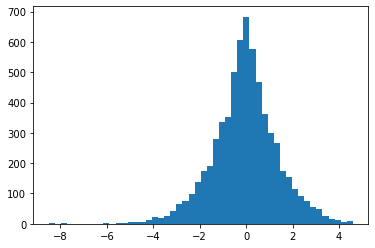

In [39]:
#checking the distribution for hpre_act
plt.hist(hpre_act.view(-1).tolist(),50);

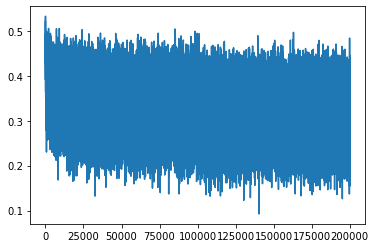

In [40]:
# type(lossi)
plt.plot(lossi)

In [66]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set  through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean / std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim = True)
    print(hpreact.shape)
    print(bnmean.shape)

torch.Size([182625, 200])
torch.Size([1, 200])


In [72]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size* n_embd)
    hpre_act = embcat @W1 +b1 #(N, n_hidden)
    #     hpre_act = bngain *(hpre_act - hpre_act.mean(0, keepdim=True)) / hpre_act.std(0, keepdim=True) +bnbias
    hpre_act = bngain * (hpre_act - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpre_act) #(N, n_hidden)
    logits = h @ W2 +b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.058687925338745
val 2.1061244010925293


In [ ]:
#loss log  #losses before and after improvements (softmax, initialization)
#original:
#aprox nrs
train 2.124 
val   2.16

# fix softmax being confidently wrong

train 2.07
val   2.13

# fix tanh layer too saturated at init
train 2.0357086658477783
val 2.1029491424560547

#kaiming init
train 2.0847249031066895
val 2.125988006591797

#after adding a batch norm layer
train 2.058983087539673
val 2.1058168411254883


In [74]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
#       print(f'probs: {(probs.shape)}')
      #sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#       print(f'ix:{ix}')
      #shift the context window
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))